In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from glimmer.model import train_neighbor_weights, set_seed
from glimmer.utils import spatial_smooth, plot_logbarrier_curve, run_logbarrier_weight

warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [3]:
# Set path 
main_path = '/data/qiyu/spatialRegion/'
fig_path = main_path + 'figures/SVG/'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans'
dir = main_path + 'data/slideseq/slideseq_cerebellum'

## 1. Run Glimmer with list of log barriers

In [9]:
seed = 42
log_barrier_list = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60, 
                    100, 300, 600, 1000, 3000, 6000, 10000]
save_path = os.path.join(dir, 'adata_log_barrier_test.h5ad')

In [ ]:
set_seed(seed)
if os.path.exists(save_path):
    adata = sc.read_h5ad(save_path)
else:
    adata = sc.read_h5ad(os.path.join(dir, 'rna_adata.h5ad'))
    sc.pp.normalize_total(adata, target_sum=1e4) 
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=3000)
    sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

    # RNA only
    sc.pp.neighbors(adata, use_rep='X_pca', random_state=seed)
    sc.tl.umap(adata, random_state=seed)
    adata.obsm["umap_RNA_only"] = adata.obsm['X_umap']

    # RNA + list of spatial weight
    adata = run_logbarrier_weight(adata, k=50, log_barrier_list=log_barrier_list, seed=seed)
    adata.write_h5ad(save_path)

Loading adata


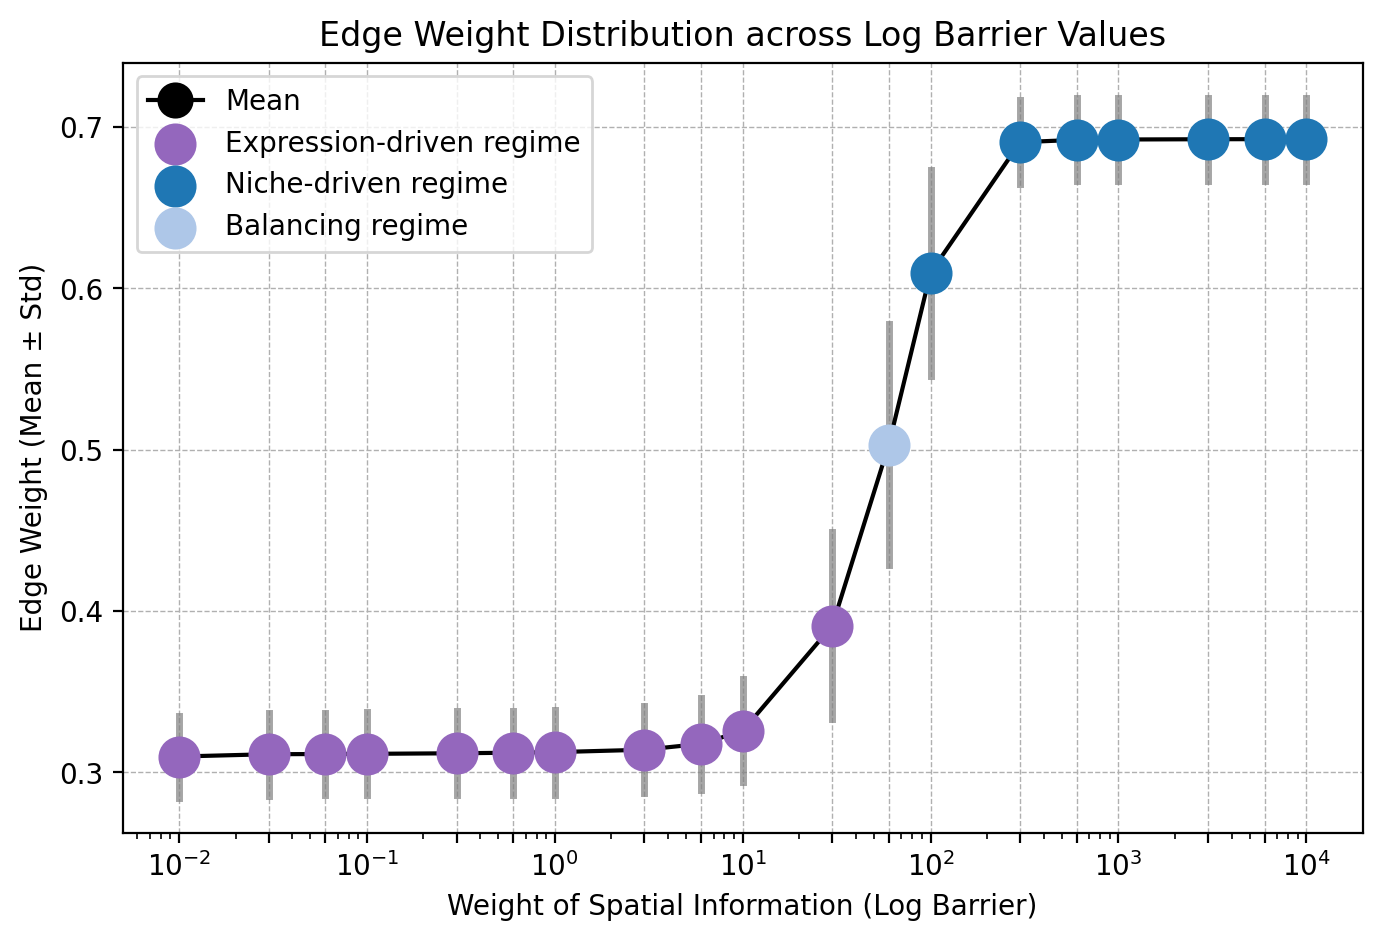

In [11]:
# Plot 
fig, ax = plot_logbarrier_curve(adata, log_barrier_list, figsize=(8, 5)) 
handles, labels = ax.get_legend_handles_labels()
label_mapping = {
    'cellular': 'Expression-driven regime',
    'transitional': 'Balancing regime',
    'regional': 'Niche-driven regime'
}
ax.legend(handles, [label_mapping.get(label, label) for label in labels])
plt.show()

## 2. Regional analysis

In [12]:
# Load processed adata 
adata_save_name = os.path.join(dir, 'rna_adata_processed.h5ad')
if os.path.exists(adata_save_name):
    print(f"Loading existing processed data")
    adata = sc.read_h5ad(adata_save_name)
else:
    # Load raw data
    adata = sc.read_h5ad(os.path.join(dir, 'rna_adata.h5ad'))
    sc.pp.normalize_total(adata, target_sum=1e4) 
    sc.pp.log1p(adata)
    sc.tl.pca(adata, svd_solver='arpack')

    # Train neighbor weights
    seed = 42
    set_seed(seed)
    adata = train_neighbor_weights(
        adata, 
        feature_emb='X_pca', 
        spatial_emb='spatial', 
        k=50, 
        spatial_w=1, 
        log_barrier_w=120, 
        sparisty_w=0.01,
        neighbor_weight=0.1, 
        num_epochs=10000, 
        cuda='cuda:0', 
        seed=seed, 
        batch=False, 
        batch_size = 2048
    )
    sc.pp.neighbors(adata, use_rep='X_emb_smooth', random_state=seed)
    sc.tl.umap(adata) 
    sc.tl.leiden(adata, resolution=0.6, random_state=seed)
    adata = spatial_smooth(adata, label_key='leiden')
    print('Weight mean', adata.obs['Weight'].mean())

Loading existing processed data


In [13]:
# Load cell type information from RCTD
cell_type_df = pd.read_csv(os.path.join(dir, "cell_type_df.csv"), index_col=0)
coords = np.load(os.path.join(dir, "cerebellum_coords_mat.npy")) 
gene_labels = np.load(os.path.join(dir, "cerebellum_gene_labels.npy"), allow_pickle=True)  
cell_type_df.insert(0, "cell_id", range(len(cell_type_df)))
cell_type_long = cell_type_df.melt(id_vars=["cell_id"], var_name="cell_type", value_name="proportion")
cell_type_long = cell_type_long.loc[cell_type_long.groupby("cell_id")["proportion"].idxmax()]
adata = adata[np.isin(adata.obsm["spatial"], coords).all(axis=1)].copy()
adata.obs["cell_type"] = cell_type_long["cell_type"].values

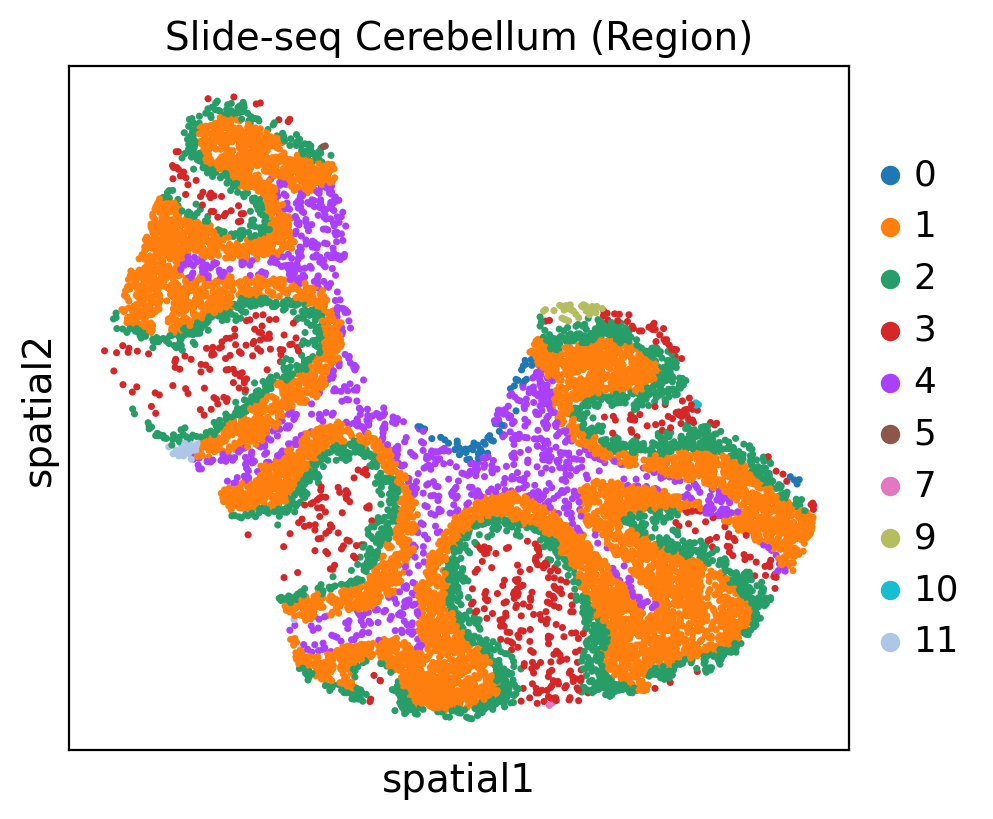

In [14]:
# Plot 
s = 26
sc.settings.set_figure_params(dpi=100, figsize=(5, 4.5))
sc.pl.embedding(adata, basis='spatial', color='region', s=s, title="Slide-seq Cerebellum (Region)", cmap='tab20') 

In [15]:
# rename regions
cluster_mapping = {
    "Granule Layer": [1, 11],
    "Purkinje Layer": [2],
    "Oligodendrocyte Layer": [0, 4],
    "Molecular Layer": [3, 5, 6, 7, 8, 9, 10]
}
cluster_key = 'region'
cluster_name_key = 'region_name'

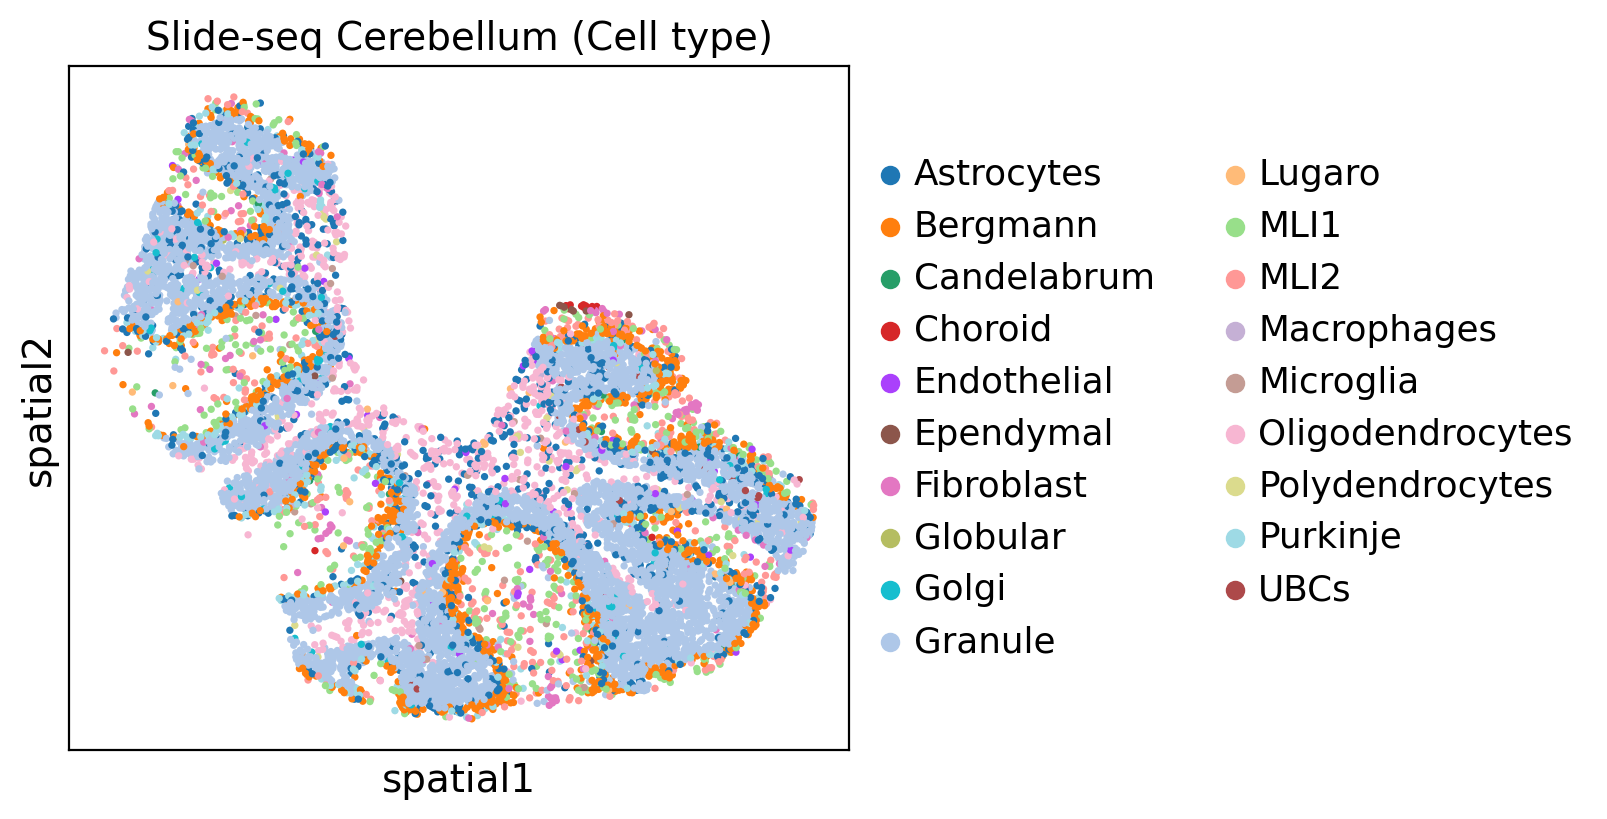

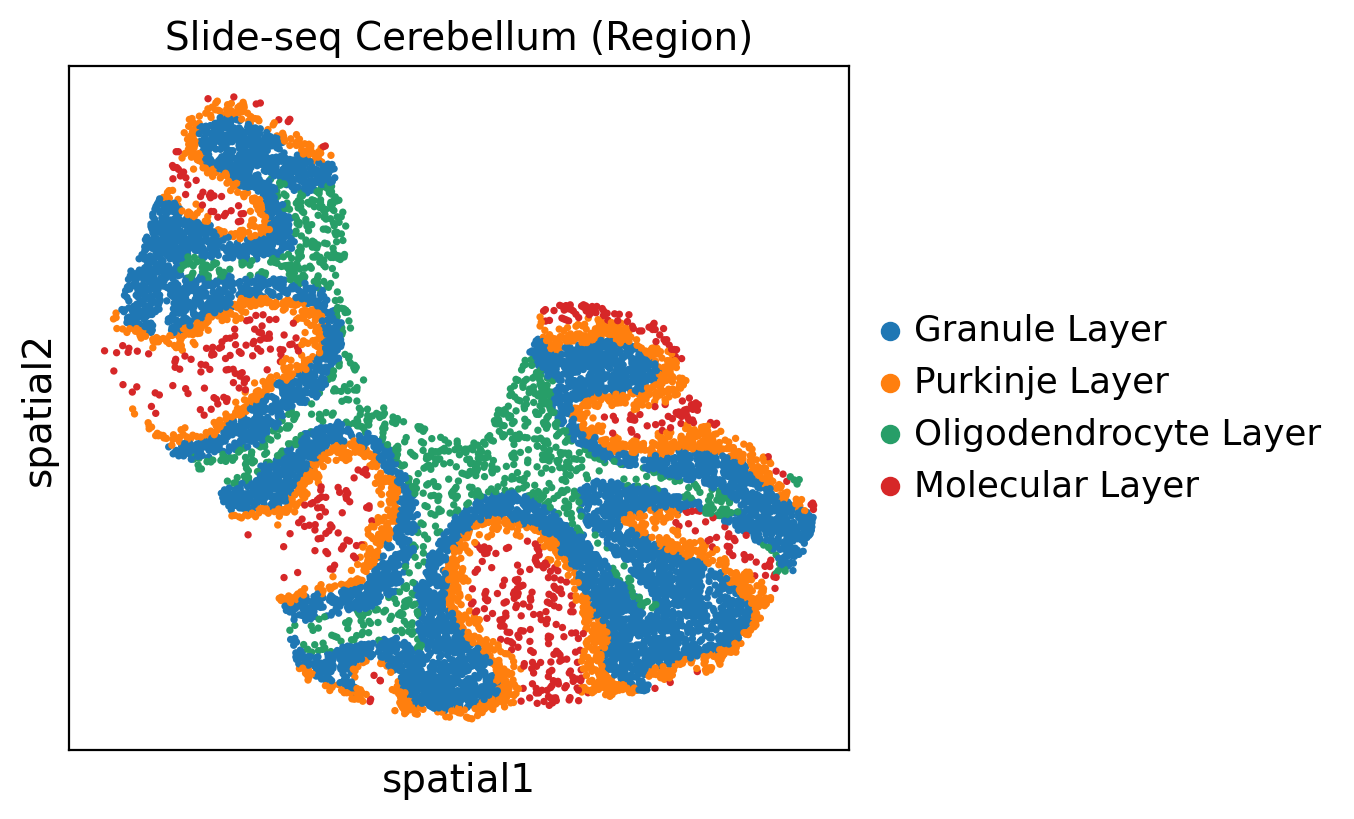

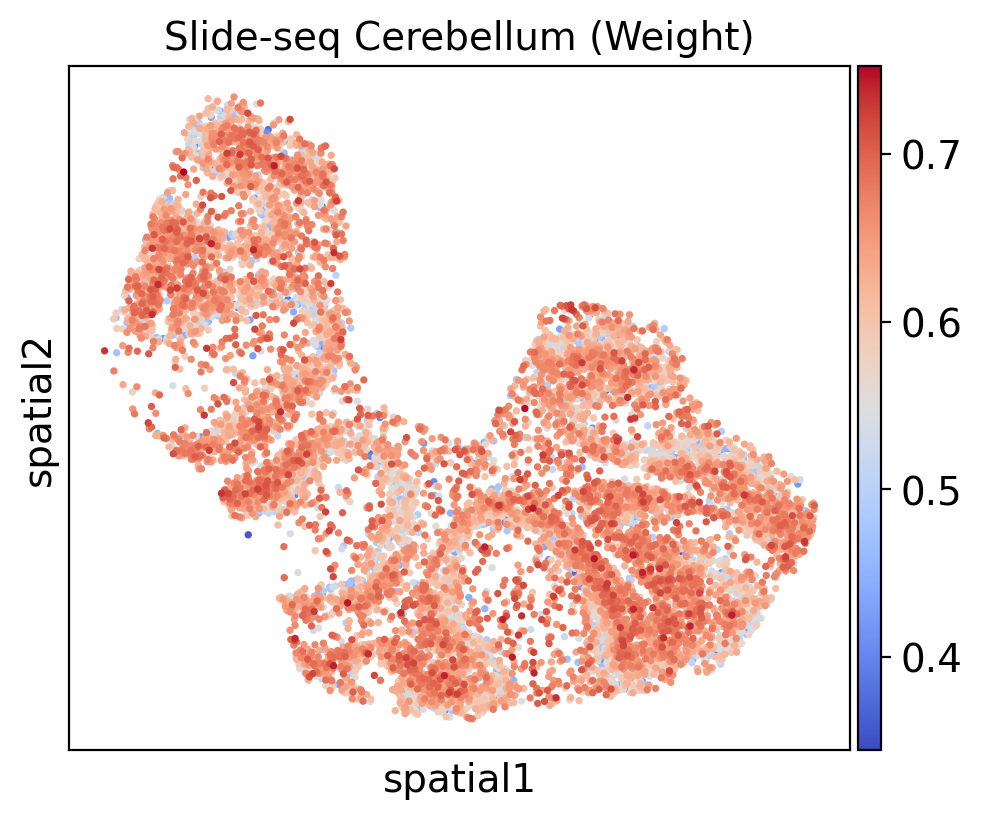

In [ ]:
s = 28
save_fig = True
fig_base_path = fig_path + 'figure3/'
fig_names = [
    fig_base_path + 'fig3_m_slideseq_cerebellum_cell_type.svg',
    fig_base_path + 'fig3_m_slideseq_cerebellum_region.svg',
    fig_base_path + 'fig3_s_slideseq_cerebellum_weight.svg'
]

# Plot and save figures
sc.settings.set_figure_params(dpi=100, figsize=(5, 4.5))
sc.pl.embedding(adata, basis='spatial', color='cell_type', s=s, title="Slide-seq Cerebellum (Cell type)", cmap='tab20', show=False)
if save_fig:
    plt.savefig(fig_names[0], format="svg", bbox_inches="tight")
plt.show()

sc.pl.embedding(adata, basis='spatial', color=cluster_name_key, s=s, title="Slide-seq Cerebellum (Region)", cmap='tab20', show=False)
if save_fig:
    plt.savefig(fig_names[1], format="svg", bbox_inches="tight")
plt.show()

sc.settings.set_figure_params(dpi=100, figsize=(5.5, 4.5))
sc.pl.embedding(adata, basis='spatial', color='Weight', s=s, title="Slide-seq Cerebellum (Weight)", cmap='coolwarm', show=False)
if save_fig:
    plt.savefig(fig_names[2], format="svg", bbox_inches="tight")
plt.show()

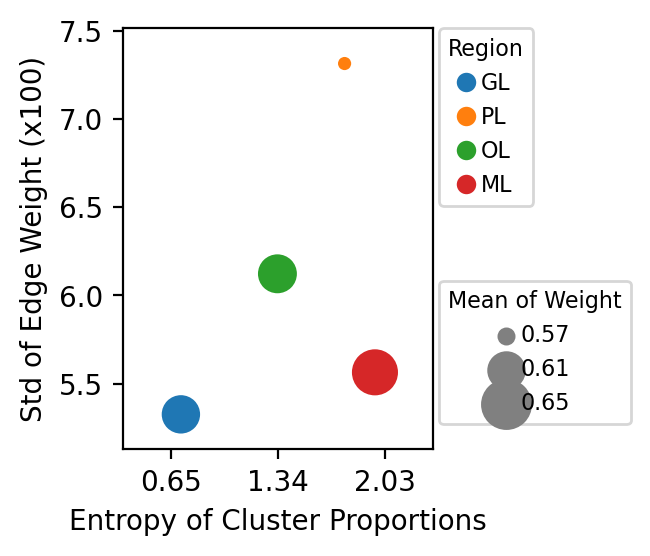

In [ ]:
from scipy.stats import entropy
from matplotlib.lines import Line2D

# Data preparation
df = pd.DataFrame({
    "region": adata.obs["region_name"].values,
    "cluster": adata.obs["cell_type"].values,
    "weight": adata.obs["Weight"].values
}, index=adata.obs_names)
region_stats = []
for region, subdf in df.groupby("region"):
    cluster_counts = subdf["cluster"].value_counts(normalize=True)
    n_clusters = len(cluster_counts)
    raw_entropy = entropy(cluster_counts)
    norm_entropy = raw_entropy / np.log2(n_clusters) if n_clusters > 1 else 0
    purity = cluster_counts.max()
    region_stats.append({
        "region": region,
        "cluster_entropy": raw_entropy,
        "cluster_entropy_norm": norm_entropy,
        "cluster_purity": purity,
        "std_graph": np.std(subdf['weight']) * 100,
        "mean_graph": np.mean(subdf['weight'])
    })
region_df = pd.DataFrame(region_stats)
region_df = region_df.sort_values("cluster_entropy", ascending=True)
region_rename_dict = {
    "Molecular Layer": "ML",
    "Purkinje Layer": "PL",
    "Oligodendrocyte Layer": "OL",
    "Granule Layer": "GL"
}
region_df["region"] = region_df["region"].replace(region_rename_dict)
region_color_dict = {
    "GL": "#1f77b4",  
    "PL": "#ff7f0e",  
    "OL": "#2ca02c",  
    "ML": "#d62728",  
}

# Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
size_min = 30
size_max = 300
scatter = sns.scatterplot(
    data=region_df,
    x="cluster_entropy",        
    y="std_graph",
    hue="region",
    size="mean_graph",
    sizes=(size_min, size_max),
    legend=False,
    palette=region_color_dict,
    ax=ax,
)
xy_data = scatter.collections[0].get_offsets()
ax.set_xlabel("Entropy of Cluster Proportions", fontsize=10)
ax.set_ylabel("Std of Edge Weight (x100)", fontsize=10)
xmin, xmax = ax.get_xlim()
xmid = (xmin + xmax) / 2
ax.set_xticks([xmin, xmid, xmax])
ax.set_xticklabels([f'{xmin:.2f}', f'{xmid:.2f}', f'{xmax:.2f}'])
ax.tick_params(labelsize=10)
region_labels = region_df["region"].unique().tolist()
region_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=region)
    for region, color in region_color_dict.items()
]
region_legend = ax.legend(
    handles=region_handles,
    title="Region",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=8,
    title_fontsize=8
)
ax.add_artist(region_legend)
size_values = np.linspace(region_df['mean_graph'].min(), region_df['mean_graph'].max(), 3)
size_sizes = np.interp(size_values, [region_df['mean_graph'].min(), region_df['mean_graph'].max()], [size_min, size_max])
size_handles = [
    plt.scatter([], [], s=s, color='gray', label=f'{v:.2f}')
    for s, v in zip(size_sizes, size_values)
]
ax.legend(
    handles=size_handles,
    title="Mean of Weight",
    bbox_to_anchor=(1.02, 0.4),
    loc='upper left',
    borderaxespad=0.,
    fontsize=8,
    title_fontsize=8
)
plt.margins(x=0.3, y=0.1)
plt.grid(False)
plt.tight_layout()
fig_name = fig_path + 'figure3/fig3_m_slideseq_cerebellum_region_edge_weight_entropy_relation.svg'
plt.savefig(fig_name, format="svg", bbox_inches="tight")
plt.show()

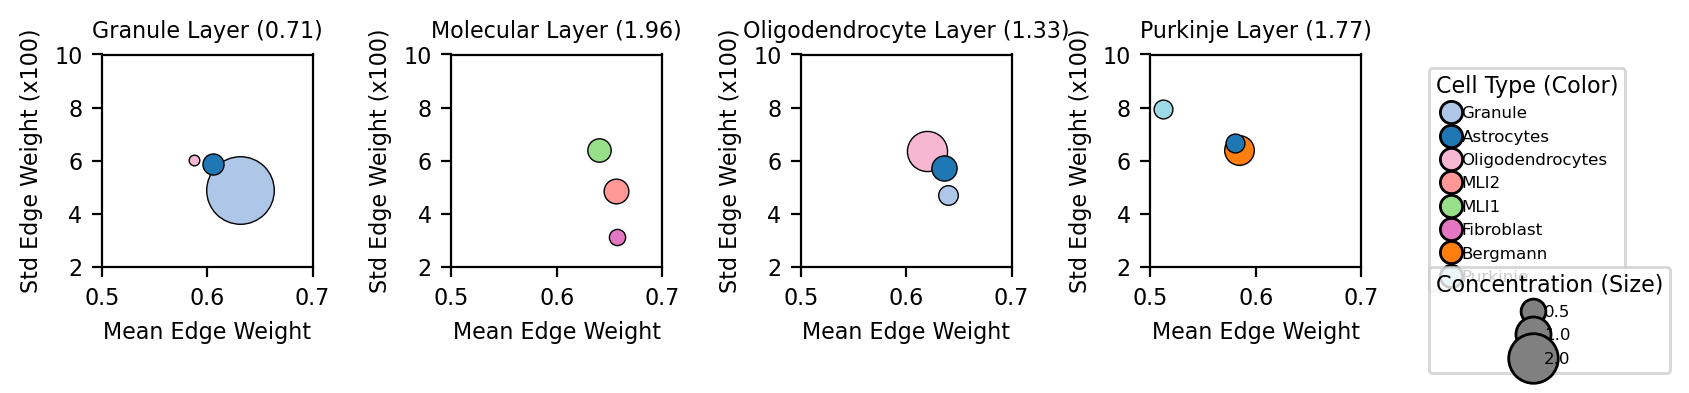

In [21]:
# Data preparation
df = pd.DataFrame({
    "region": adata.obs["region_name"].values,
    "cluster": adata.obs["cell_type"].values,
    "weight": adata.obs["Weight"].values
}, index=adata.obs_names)
n_top = 3
region_cluster_stats = []
for region, subdf_region in df.groupby("region"):
    cluster_counts = subdf_region["cluster"].value_counts(normalize=True)
    total_entropy = entropy(cluster_counts)
    for cluster, proportion in cluster_counts.items():
        subdf_cluster = subdf_region[subdf_region["cluster"] == cluster]
        region_cluster_stats.append({
            "region": region,
            "cluster": cluster,
            "proportion": proportion,
            "entropy": total_entropy,
            "mean_graph": np.mean(subdf_cluster["weight"]),
            "std_graph": np.std(subdf_cluster["weight"]) * 100,
            "concentration": proportion / (total_entropy + 1e-5)
        })
region_cluster_df = pd.DataFrame(region_cluster_stats)
top_df = (
    region_cluster_df
    .sort_values(["region", "proportion"], ascending=[True, False])
    .groupby("region")
    .head(n_top)
    .reset_index(drop=True)
)

# Plot
scanpy_clusters = list(adata.obs["cell_type"].cat.categories)
scanpy_colors = adata.uns["cell_type_colors"]
cluster_color_dict = dict(zip(scanpy_clusters, scanpy_colors))
regions = top_df["region"].unique().tolist()
plotted_clusters = top_df["cluster"].unique().tolist()
n = len(regions)
n_cols = 4
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))
axes = axes.flatten()
for i, region in enumerate(regions):
    ax = axes[i]
    region_data = top_df[top_df["region"] == region]
    for _, row in region_data.iterrows():
        cluster = row["cluster"]
        color = cluster_color_dict.get(cluster, "gray")
        size = row["concentration"] * 500
        ax.scatter(row["mean_graph"], row["std_graph"], s=size, c=[color], edgecolors='black', linewidths=0.5)
    ax.set_title(f"{region} ({region_data['entropy'].iloc[0]:.2f})", fontsize=8)
    ax.set_xlabel("Mean Edge Weight", fontsize=8)
    ax.set_ylabel("Std Edge Weight (x100)", fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.set_xticks([0.5, 0.6, 0.7])
    ax.set_yticks([2, 4, 6, 8, 10])
    ax.grid(False)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
cluster_handles = [
    Line2D([0], [0], marker='o', color='w', label=cluster,
           markerfacecolor=cluster_color_dict.get(cluster, "gray"),
           markeredgecolor='black', markersize=8)
    for cluster in plotted_clusters
]
fig.legend(handles=cluster_handles, title="Cell Type (Color)", loc='center left', 
           bbox_to_anchor=(0.9, 0.5), fontsize=6, title_fontsize=8)
plt.tight_layout(rect=[0, 0, 0.9, 1])

from matplotlib.lines import Line2D
example_concentrations = [0.5, 1.0, 2.0]
size_scaling = 500 
size_handles = [
    Line2D([0], [0], marker='o', color='w', label=f'{c:.1f}',
           markerfacecolor='gray', markeredgecolor='black',
           markersize=np.sqrt(c * size_scaling / np.pi))
    for c in example_concentrations
]
fig.legend(handles=size_handles, title="Concentration (Size)",
           loc='center left', bbox_to_anchor=(0.9, 0.15), fontsize=6, title_fontsize=8)

fig_name = fig_path + 'figure3/fig3_m_slideseq_cerebellum_region_edge_weight_entropy_relation_split.svg'
plt.savefig(fig_name, format="svg", bbox_inches="tight")
plt.show()

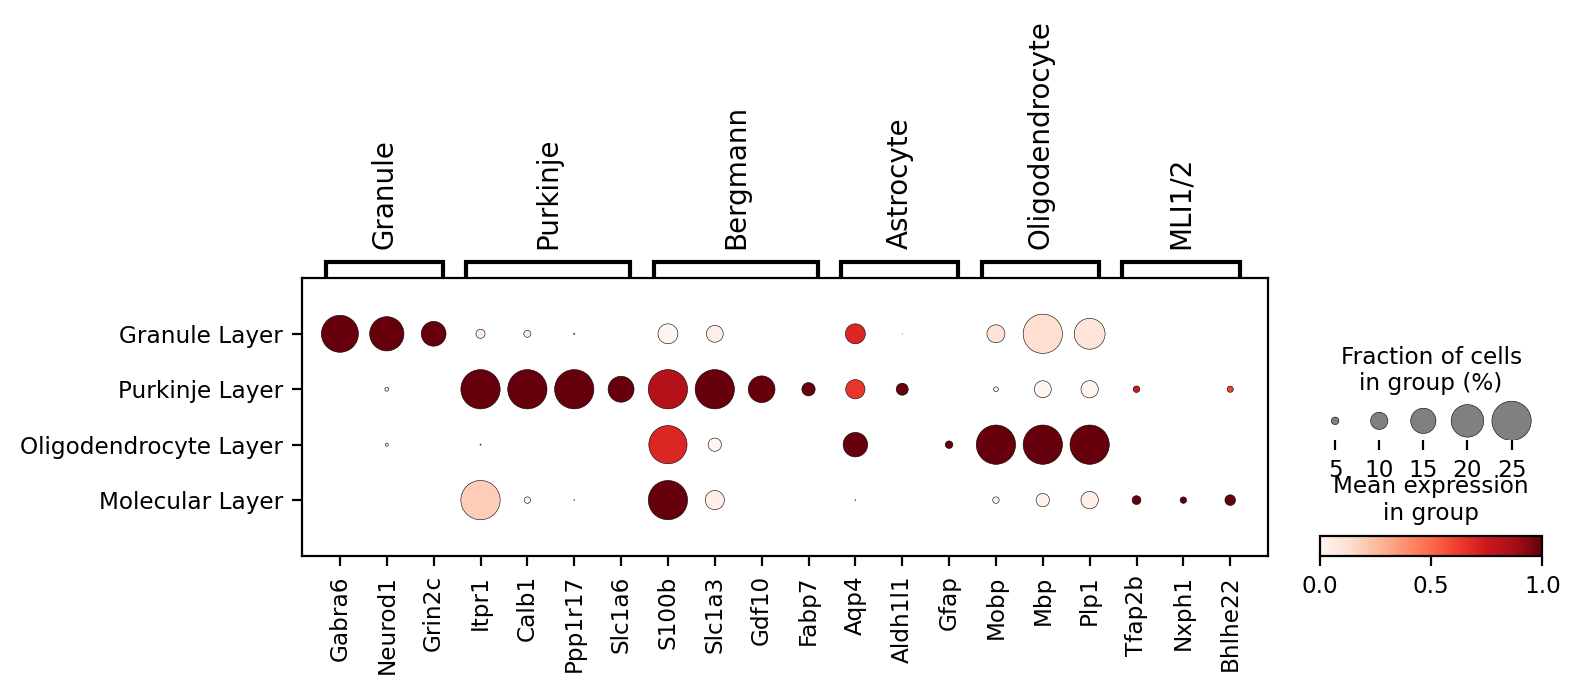

In [83]:
dict_marker = {
    "Granule": ["Gabra6", "Neurod1", "Grin2c"],  
    "Purkinje": ["Itpr1", "Calb1", "Ppp1r17", "Slc1a6"], 
    "Bergmann": ["S100b", "Slc1a3", "Gdf10", "Fabp7"], 
    "Astrocyte": ["Aqp4", "Aldh1l1", "Gfap"],   
    "Oligodendrocyte": ["Mobp", "Mbp", "Plp1"],  
    "MLI1/2": ["Tfap2b", "Nxph1", "Bhlhe22"]
}
dotplot_fig_path = os.path.join(fig_base_path, 'fig3_m_slideseq_cerebellum_gene_dotplot.svg')
sc.pl.dotplot(adata, var_names=dict_marker, groupby='region_name', standard_scale='var',
              figsize=(8, 1.8), dot_max=0.25, dot_min=0.025, swap_axes=False, show=False)
plt.gcf().savefig(dotplot_fig_path, format="svg", bbox_inches="tight")
plt.show() 

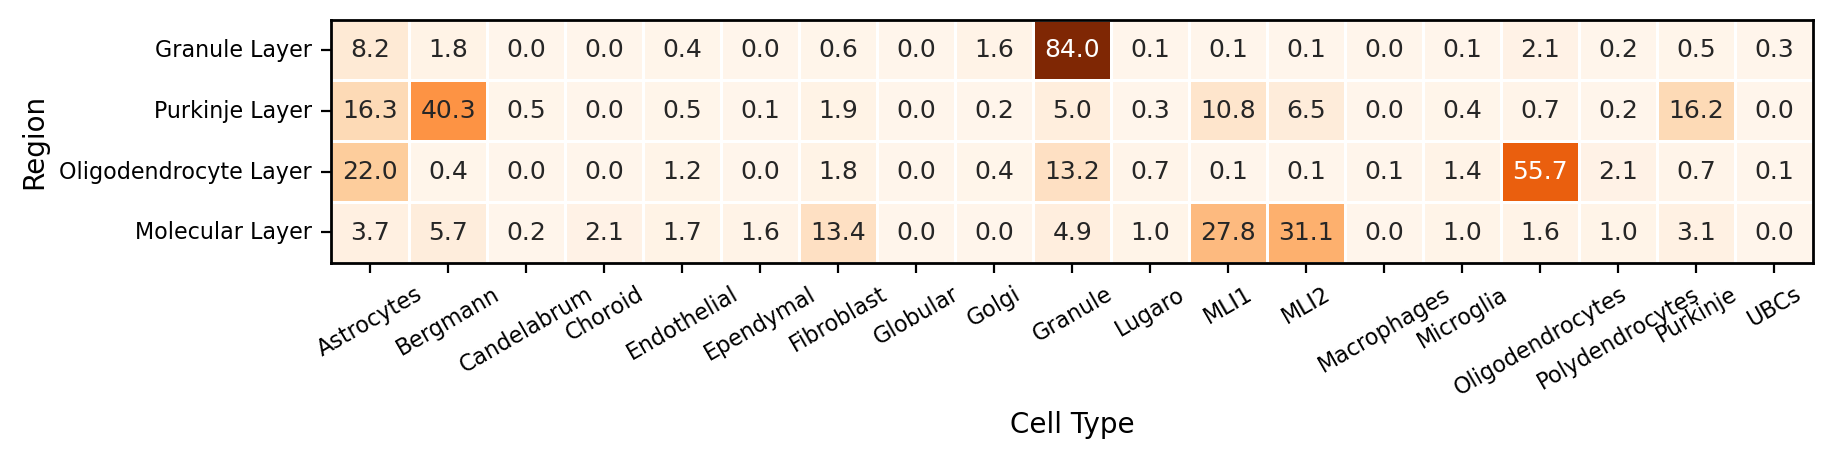

In [29]:
count_matrix = (
    adata.obs.groupby(["region_name", "cell_type"])
    .size()
    .unstack(fill_value=0) 
)
percent_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0) * 100  
fig_width = max(5, len(percent_matrix.columns) * 0.5)
fig_height = len(percent_matrix.index) * 0.4
plt.figure(figsize=(fig_width, fig_height))
ax = sns.heatmap(
    percent_matrix,
    cmap="Oranges",
    annot=True,
    fmt=".1f",
    linewidths=1,
    annot_kws={"size": 9},
    cbar=False
)
ax.set_xlabel("Cell Type", fontsize=10)
ax.set_ylabel("Region", fontsize=10)
ax.tick_params(axis="x", labelsize=8, rotation=30)
ax.tick_params(axis="y", labelsize=8)
plt.grid(False)
plt.title("", fontsize=16, pad=20)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color("black")
fig_name = fig_path + 'figure3/fig3_s_slideseq_cerebellum_cell_type_proportion_heatmap.svg'
plt.savefig(fig_name, format="svg", bbox_inches="tight")
plt.show()